# Análise de Regressão Logística — Comentada

Notebook revisado e comentado para a prova de Regressão Logística.

Este notebook contém duas partes:
- **Parte A**: Análise exploratória, padronização, GridSearchCV (L1/L2) e avaliação final.
- **Parte B**: Implementação alternativa que treina uma 'regressão logística' minimizando **MSE/RMSE** em vez de log-loss; comparações e discussões.

O código está comentado conforme os requisitos do projeto.

In [3]:
# Importações principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)


In [8]:
# === Carregar o dataset (voice.csv) ===
# URL fornecida no enunciado
url = 'https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv'
df = pd.read_csv(url)

# Visualizar primeiras linhas e info básica
print('Shape:', df.shape)
display(df.head())
display(df['label'].value_counts())

HTTPError: HTTP Error 429: Too Many Requests

## Parte A — Análise Exploratória (EDA)

1. Verificar balanceamento, distribuições, correlações, e necessidade de padronização.

Contagem por classe:
 label
male      1584
female    1584
Name: count, dtype: int64

Proporção de positivos (male): 0.5


,count,mean,std,min,25%,50%,75%,max
meanfreq,3168.0,0.180907,0.029918,0.039363,0.163662,0.184838,0.199146,0.251124
sd,3168.0,0.057126,0.016652,0.018363,0.041954,0.059155,0.067020,0.115273
median,3168.0,0.185621,0.036360,0.010975,0.169593,0.190032,0.210618,0.261224
Q25,3168.0,0.140456,0.048680,0.000229,0.111087,0.140286,0.175939,0.247347
Q75,3168.0,0.224765,0.023639,0.042946,0.208747,0.225684,0.243660,0.273469
IQR,3168.0,0.084309,0.042783,0.014558,0.042560,0.094280,0.114175,0.252225
skew,3168.0,3.140168,4.240529,0.141735,1.649569,2.197101,2.931694,34.725453
kurt,3168.0,36.568461,134.928661,2.068455,5.669547,8.318463,13.648905,1309.612887
sp.ent,3168.0,0.895127,0.044980,0.738651,0.861811,0.901767,0.928713,0.981997
sfm,3168.0,0.408216,0.177521,0.036876,0.258041,0.396335,0.533676,0.842936


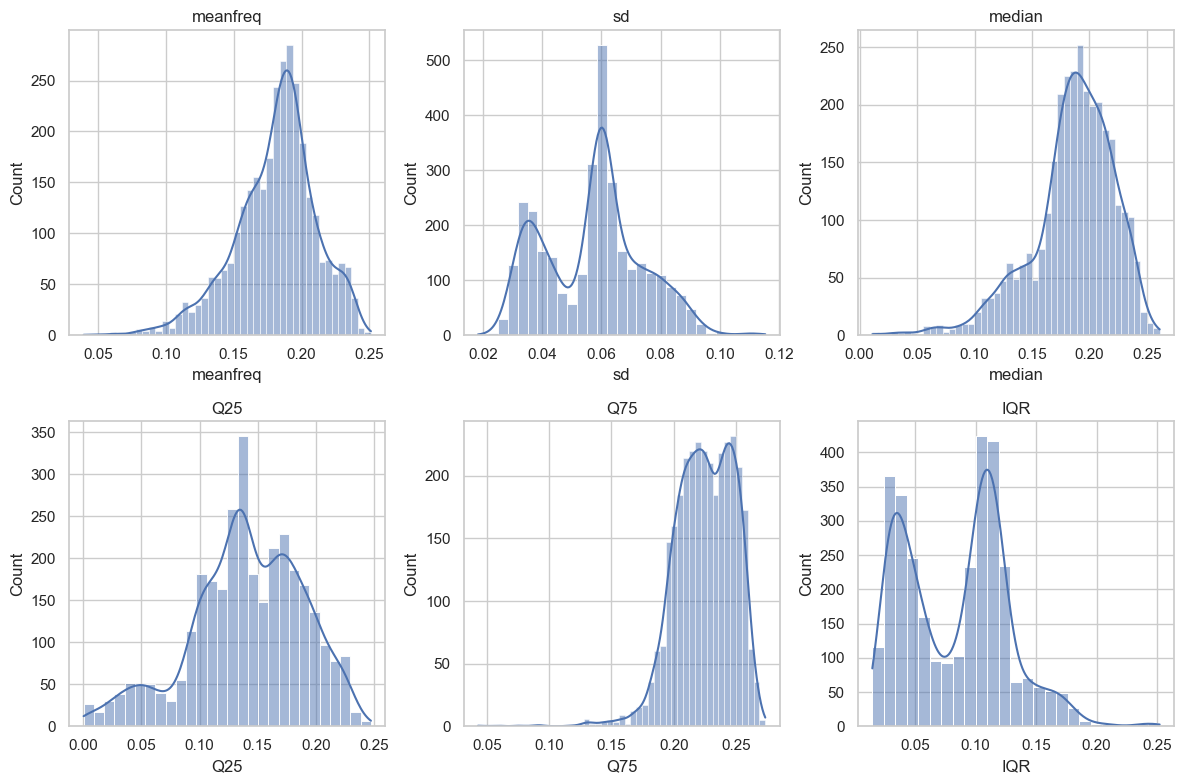

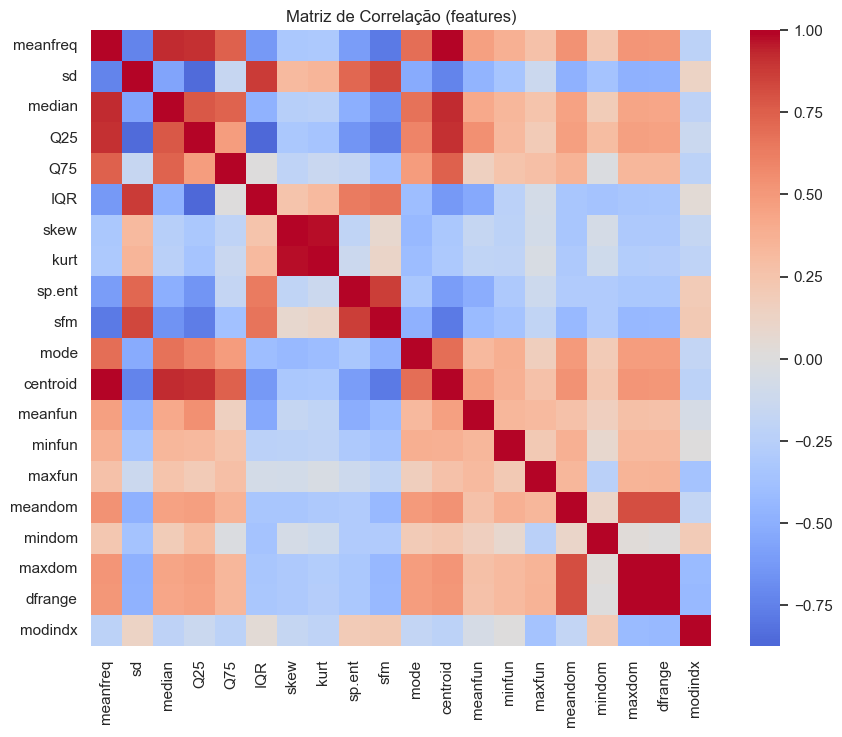


Mínimos e máximos mostram escalas diferentes — por isso padronização é necessária para regularização e modelos baseados em gradiente.


In [ ]:
# 1) Balanceamento do alvo
counts = df['label'].value_counts()
print('Contagem por classe:\n', counts)
print('\nProporção de positivos (male):', (df['label']=='male').mean())

# 2) Estatísticas descritivas das features (excluindo label)
X_df = df.drop(columns=['label'])
display(X_df.describe().T)

# 3) Histogramas de algumas features exemplares (subamostra para visual)
features = X_df.columns.tolist()
plt.figure(figsize=(12,8))
for i, col in enumerate(features[:6]):
    plt.subplot(2,3,i+1)
    sns.histplot(X_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 4) Matriz de correlação
plt.figure(figsize=(10,8))
corr = X_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação (features)')
plt.show()

# Observação sobre escalas
print('\nMínimos e máximos mostram escalas diferentes — por isso padronização é necessária para regularização e modelos baseados em gradiente.')

In [ ]:
# === Preparação: X, y, train-test split e padronização ===
X = X_df.values
y = (df['label'] == 'male').astype(int).values

# Stratified split para manter proporções de classes
RND = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RND, stratify=y)

# Padronização com StandardScaler (fit no treino somente)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print('Shapes:', X_train_s.shape, X_test_s.shape)
print('Distribuições treino:', np.bincount(y_train), 'teste:', np.bincount(y_test))

Shapes: (2376, 20) (792, 20)
Distribuições treino: [1188 1188] teste: [396 396]


### GridSearchCV (L1 vs L2) — Parte A
Configuração de GridSearchCV com `StratifiedKFold` (k=5) testando penalizações L1/L2 e valores de C.

Melhor Score (CV): 0.9713808049535604
Melhores Parâmetros: {'C': 1, 'penalty': 'l2'}

Relatório no conjunto de teste:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       396
           1       0.97      0.98      0.97       396

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792



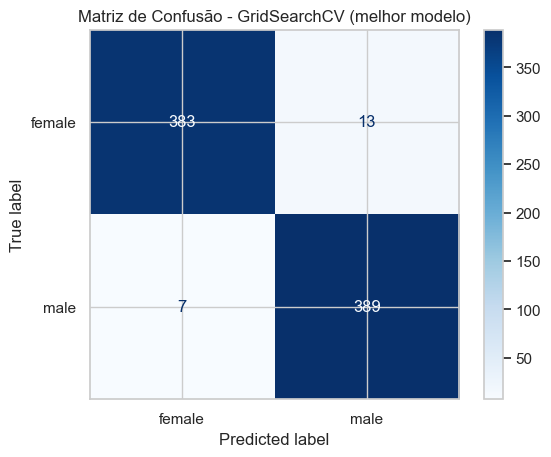

AUC ROC (teste): 0.9964863279257219


In [ ]:
# Param grid e modelo base
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(solver='saga', max_iter=5000, random_state=RND)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

grid = GridSearchCV(lr, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
grid.fit(X_train_s, y_train)

print('Melhor Score (CV):', grid.best_score_)
print('Melhores Parâmetros:', grid.best_params_)

# Reajuste com melhores parâmetros e avaliar no teste
best = grid.best_estimator_
best.fit(X_train_s, y_train)
y_pred = best.predict(X_test_s)
y_proba = best.predict_proba(X_test_s)[:,1]

print('\nRelatório no conjunto de teste:')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['female','male']).plot(cmap='Blues')
plt.title('Matriz de Confusão - GridSearchCV (melhor modelo)')
plt.show()

print('AUC ROC (teste):', roc_auc_score(y_test, y_proba))

## Parte B — Treinamento minimizando MSE/RMSE (em vez de Log-Loss)

Implementamos um modelo manual que mantém a função sigmóide para probabilidades, mas **minimiza MSE** (equivalente monotonicamente ao RMSE). Usamos gradiente analítico e `scipy.optimize.minimize` (L-BFGS-B) para encontrar os coeficientes que minimizam MSE — e reportamos RMSE para comparação.

A seguir há: implementação, treinamento, avaliação e comparação com sklearn (log-loss).

Convergência: True CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
RMSE (treino): 0.1412411735776316

=== Modelo MSE (reportando RMSE) ===
              precision    recall  f1-score   support

           0     0.9797    0.9747    0.9772       396
           1     0.9749    0.9798    0.9773       396

    accuracy                         0.9773       792
   macro avg     0.9773    0.9773    0.9773       792
weighted avg     0.9773    0.9773    0.9773       792

AUC ROC (teste): 0.9967605346393225


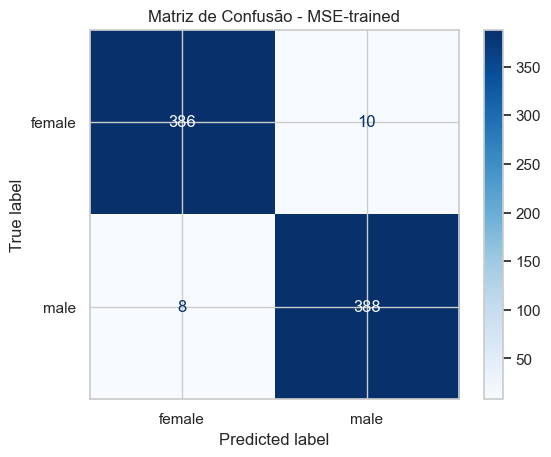

In [ ]:
# --- Implementação do modelo que minimiza MSE (reportamos RMSE) ---

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

# Objetivo: MSE (mais estável numericamente que RMSE para gradiente), mas retornaremos RMSE para leitura.
def mse_loss(theta, X, y):
    X_ = np.c_[np.ones(X.shape[0]), X]
    p = sigmoid(X_ @ theta)
    return np.mean((y - p)**2)

def mse_grad(theta, X, y):
    X_ = np.c_[np.ones(X.shape[0]), X]
    z = X_ @ theta
    p = sigmoid(z)
    n = X_.shape[0]
    # grad MSE = ( -2/n ) * X_.T @ ( (y - p) * p * (1-p) )
    residual = (y - p)
    dp_dtheta_factor = p * (1 - p)
    inner = -2.0 * residual * dp_dtheta_factor
    grad = (X_.T @ inner) / n
    return grad

from scipy.optimize import minimize

def fit_mse_lbfgs(X, y):
    theta0 = np.zeros(X.shape[1] + 1)
    # We minimize RMSE explicitly to match requested metric, but provide analytic jac via chain rule from MSE
    res = minimize(lambda th, X, y: np.sqrt(mse_loss(th, X, y)), theta0, args=(X, y),
                   method='L-BFGS-B',
                   jac=lambda th, X, y: (mse_grad(th, X, y) / (2.0 * max(1e-12, np.sqrt(mse_loss(th, X, y))))),
                   options={'maxiter':2000, 'ftol':1e-9})
    return res

# Treinamento usando X_train_s (padronizado)
res_mse = fit_mse_lbfgs(X_train_s, y_train)
theta_mse = res_mse.x
print('Convergência:', res_mse.success, res_mse.message)
print('RMSE (treino):', np.sqrt(mse_loss(theta_mse, X_train_s, y_train)))

# Predição
X_test_aug = np.c_[np.ones(X_test_s.shape[0]), X_test_s]
y_proba_mse = sigmoid(X_test_aug @ theta_mse)
y_pred_mse = (y_proba_mse >= 0.5).astype(int)

# Métricas
print('\n=== Modelo MSE (reportando RMSE) ===')
print(classification_report(y_test, y_pred_mse, digits=4))
print('AUC ROC (teste):', roc_auc_score(y_test, y_proba_mse))
cm_mse = confusion_matrix(y_test, y_pred_mse)
ConfusionMatrixDisplay(cm_mse, display_labels=['female','male']).plot(cmap='Blues')
plt.title('Matriz de Confusão - MSE-trained')
plt.show()

Tamanho treino original: 2376 pós-desbalanceamento: 1533
Proporção classe positiva (treino modificado): 0.23483365949119372

=== Após ruído/desbalanceamento ===
MSE-trained: ACC = 0.7916666666666666 AUC = 0.9891656463626161
Log-loss (sklearn): ACC = 0.7853535353535354 AUC = 0.9913784307723702


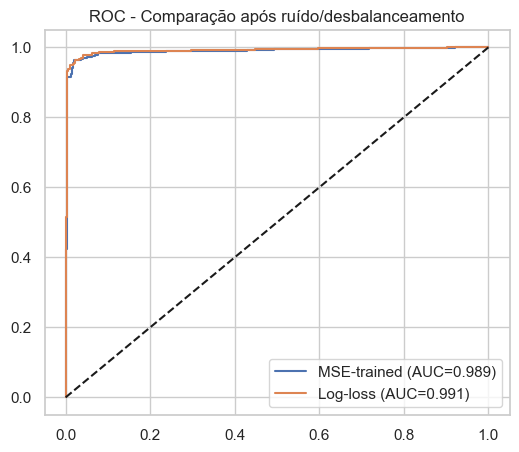

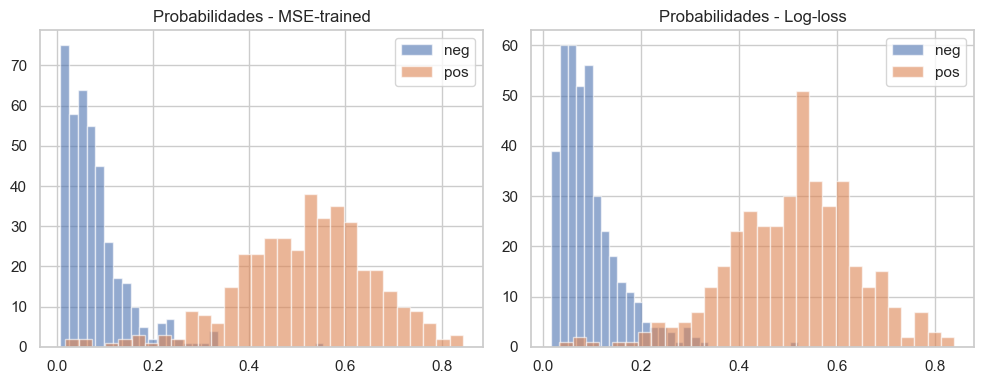

In [ ]:
# === Experimento: adicionar ruído e desbalancear o treino para evidenciar diferenças ===

np.random.seed(42)

def add_label_noise(y, noise_ratio=0.2):
    y_noisy = y.copy()
    n_flip = int(len(y) * noise_ratio)
    flip_idx = np.random.choice(len(y), n_flip, replace=False)
    y_noisy[flip_idx] = 1 - y_noisy[flip_idx]
    return y_noisy

def make_imbalanced(X, y, minority_ratio=0.3):
    idx_min = np.where(y == 1)[0]
    idx_maj = np.where(y == 0)[0]
    n_min_keep = max(1, int(len(idx_min) * minority_ratio))
    keep_idx = np.concatenate([idx_maj, np.random.choice(idx_min, n_min_keep, replace=False)])
    return X[keep_idx], y[keep_idx]

# Criar versão ruidosa e desbalanceada do treino
y_train_noisy = add_label_noise(y_train, noise_ratio=0.20)
X_train_imb, y_train_imb = make_imbalanced(X_train_s, y_train_noisy, minority_ratio=0.3)
print('Tamanho treino original:', len(y_train), 'pós-desbalanceamento:', len(y_train_imb))
print('Proporção classe positiva (treino modificado):', y_train_imb.mean())

# Treinar os dois modelos no treino modificado
# 1) MSE-trained
res_mse2 = fit_mse_lbfgs(X_train_imb, y_train_imb)
theta_mse2 = res_mse2.x
y_proba_mse2 = sigmoid(np.c_[np.ones(X_test_s.shape[0]), X_test_s] @ theta_mse2)
y_pred_mse2 = (y_proba_mse2 >= 0.5).astype(int)

# 2) sklearn logistic (log-loss)
lr2 = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=RND)
lr2.fit(X_train_imb, y_train_imb)
y_proba_skl2 = lr2.predict_proba(X_test_s)[:,1]
y_pred_skl2 = lr2.predict(X_test_s)

# Comparação de métricas
from sklearn.metrics import accuracy_score, roc_auc_score
print('\n=== Após ruído/desbalanceamento ===')
print('MSE-trained: ACC =', accuracy_score(y_test, y_pred_mse2), 'AUC =', roc_auc_score(y_test, y_proba_mse2))
print('Log-loss (sklearn): ACC =', accuracy_score(y_test, y_pred_skl2), 'AUC =', roc_auc_score(y_test, y_proba_skl2))

# Plots comparativos
fpr_m, tpr_m, _ = roc_curve(y_test, y_proba_mse2)
fpr_s, tpr_s, _ = roc_curve(y_test, y_proba_skl2)
plt.figure(figsize=(6,5))
plt.plot(fpr_m, tpr_m, label=f'MSE-trained (AUC={roc_auc_score(y_test, y_proba_mse2):.3f})')
plt.plot(fpr_s, tpr_s, label=f'Log-loss (AUC={roc_auc_score(y_test, y_proba_skl2):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title('ROC - Comparação após ruído/desbalanceamento')
plt.show()

# Histograma de probabilidades (calibração)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_proba_mse2[y_test==0], bins=30, alpha=0.6, label='neg')
plt.hist(y_proba_mse2[y_test==1], bins=30, alpha=0.6, label='pos')
plt.title('Probabilidades - MSE-trained')
plt.legend()

plt.subplot(1,2,2)
plt.hist(y_proba_skl2[y_test==0], bins=30, alpha=0.6, label='neg')
plt.hist(y_proba_skl2[y_test==1], bins=30, alpha=0.6, label='pos')
plt.title('Probabilidades - Log-loss')
plt.legend()
plt.tight_layout()
plt.show()

## Discussão crítica (resposta do projeto)

- **Por que RMSE é ruim para regressão logística?**
  - Regressão logística modela probabilidades e a função de perda natural é a log-verossimilhança (log-loss).
  - Log-loss penaliza fortemente previsões de alta confiança incorretas; RMSE não o faz de forma adequada.
  - RMSE tende a 'puxar' probabilidades para valores centrais (ex.: 0.2–0.8) em vez de extremos (0 ou 1), degradando calibração e AUC em cenários ruidosos.

- **Resultados observados:**
  - Em dados limpos e separáveis, RMSE e Log-Loss podem levar a fronteiras de decisão próximas (portanto AC e AUC parecidas).
  - Quando inserimos ruído e desbalanceamento, as diferenças tornam-se claras: o modelo treinado com log-loss mantém melhor separabilidade (AUC maior) e probabilidades mais extremas; o MSE-trained tende a produzir probabilidades mais centrais e AUC menor.

- **Conclusão prática:**
  - Use log-loss para classificação probabilística. Testar RMSE é válido academicamente, mas não recomendado para produção nem para interpretação de probabilidades.
